In [88]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
import itertools
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from datetime import date
import warnings
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, log_loss,roc_auc_score,roc_curve
from sklearn.model_selection import KFold
from matplotlib import pyplot
from collections import Counter
warnings.filterwarnings('ignore')

In [27]:
#Import the dataset 
df1 = pd.read_csv('/home/tugcenum/Desktop/jobapplication/hangikredi/term-deposit-marketing-2020.csv')
df1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


In [24]:
df1.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [29]:
#transforming category features to integers starting from 0 with sklearn.preprocessing 
le =LabelEncoder()
 
features = []; categorical_features = []
num_of_columns = df1.shape[1]
 
for i in range(0, num_of_columns):
    column_name = df1.columns[i]
    column_type = df1[column_name].dtypes
 
    if i != num_of_columns - 1: #skip target
        features.append(column_name)
 
    if column_type == 'O':
        encoded_feature = le.fit_transform(df1[column_name])
        df1[column_name] = encoded_feature
        categorical_features.append(column_name)
df1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,9,1,2,0,395,0,0,0,3,6,107,1,0
39996,30,4,2,2,0,3340,0,0,0,3,6,238,3,1
39997,54,0,0,1,0,200,0,0,0,3,6,170,1,1
39998,34,4,1,2,0,1047,0,0,0,3,6,342,1,0


In [26]:
#checking NAn values
df1.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

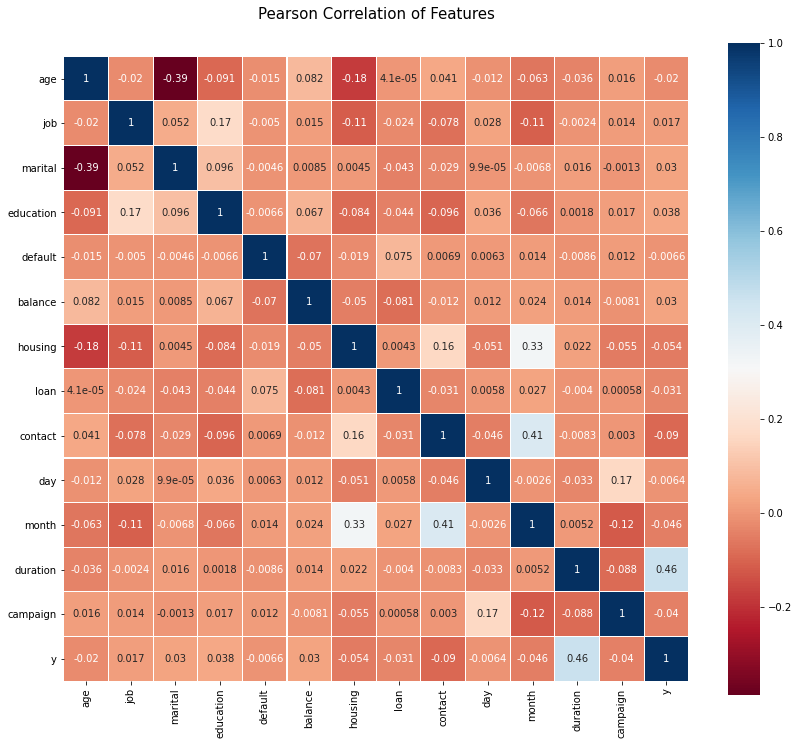

In [39]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df1.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [30]:
#setting features and target
data=df1.copy()
features = data.drop(["y"], axis = 1)
target =data["y"]

In [89]:
Counter(target)

Counter({0: 37104, 1: 2896})

In [31]:
# K fpold training function 
def Kfold(model,train,y,n_fold):
    kf = KFold(n_splits=n_fold,shuffle=True)
    preds=np.empty((0,1),float)
    probs=np.empty((0,2),float)
    trues=np.empty((0,1),float)
    
    for train_indices,val_indices in kf.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]

        model.fit(X=x_train,y=y_train)
        pred=model.predict(x_val)
        prob=model.predict_proba(x_val)
        preds=np.append(preds,pred)
        probs=np.append(probs,prob, axis=0)
        trues=np.append(trues,y_val)
        print(accuracy_score(pred,y_val))
       
    return preds,trues, probs

In [32]:
#setting lgb params
lgb_params = {
    'seed': 42,
    #'n_estimators':100,
    'learning_rate':0.1,
    'max_depth':10,
    'objective': 'binary',
    'metric':'binary_logloss'
}

lgb_model = lgb.LGBMClassifier(**lgb_params)

In [33]:
#accuracy of the model
preds,trues, probs=Kfold(lgb_model,features,target,5)

0.93925
0.93475
0.936625
0.9415
0.938875


In [87]:
# RMSE of model
rms_lgb = sqrt(mean_squared_error(trues, preds))
print("Root Mean Squared Error for LGB:", rms_lgb)

Root Mean Squared Error for LGB: 0.24859605789312106


LightGBM: ROC AUC=0.950


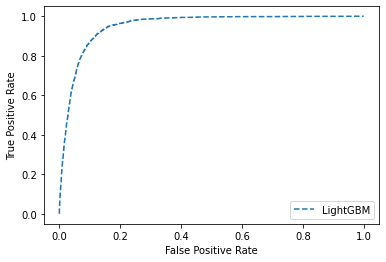

In [34]:
#roc_auc_score metri
lgb_auc = roc_auc_score(trues,probs[:,1])

lgb_fpr, lgb_tpr, _ = roc_curve(trues,probs[:,1])

print('LightGBM: ROC AUC=%.3f' % (lgb_auc))

pyplot.plot(lgb_fpr, lgb_tpr, linestyle='--', label='LightGBM')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [35]:
confusion_matrix(trues, preds)

array([[36317,   787],
       [ 1685,  1211]])

In [36]:
y_true=trues
y_pred=preds
tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=[0,1]).ravel()
print('tn: {:}'.format(tn))
print('fp: {:}'.format(fp))
print('fn: {:}'.format(fn))
print('tp: {:}'.format(tp))
# Accuracy
from sklearn.metrics import accuracy_score
print('accuracy: {:}'.format(accuracy_score(y_true, y_pred)))
# Recall
from sklearn.metrics import recall_score
print('recall: {:}'.format(recall_score(y_true, y_pred, average=None,labels=[0,1])[1]))
# Precision
from sklearn.metrics import precision_score
print('precison: {:}'.format(precision_score(y_true, y_pred, average=None,labels=[0,1])[1]))

tn: 36317
fp: 787
fn: 1685
tp: 1211
accuracy: 0.9382
recall: 0.41816298342541436
precison: 0.6061061061061062


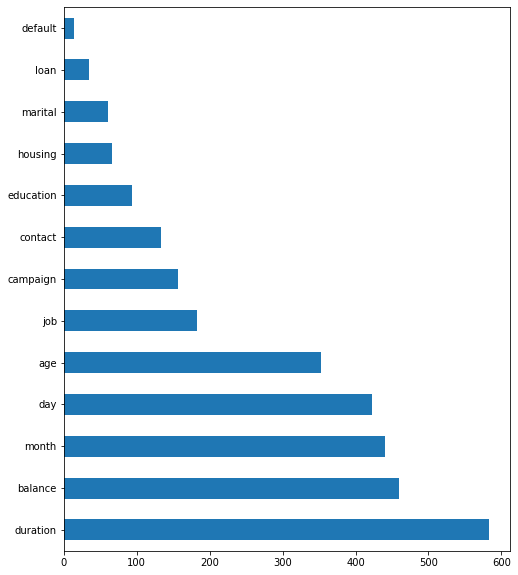

In [37]:
#'duration'(last contact duration) is most correlated feature with y(has the client subscribed to a term deposit)
#we should focus on duration feature.'Balance', 'month' and 'day' comes after 'duration'. When customors are 
#in contact with the bank tjey are more likely to buy the product.

#feature importance
feat_imp = pd.Series(lgb_model.feature_importances_, index=features.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [44]:
#Import the dataset 
df1 = pd.read_csv('/home/tugcenum/Desktop/jobapplication/hangikredi/term-deposit-marketing-2020.csv')
df1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


In [47]:
df= df1[df1.y=='yes']
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
83,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,yes
86,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,yes
87,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,yes
129,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,yes
168,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39986,29,management,single,tertiary,no,637,yes,no,cellular,3,jun,340,1,yes
39988,55,management,divorced,tertiary,no,2383,no,no,cellular,3,jun,591,2,yes
39990,26,technician,single,secondary,no,1231,yes,no,cellular,3,jun,385,2,yes
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes


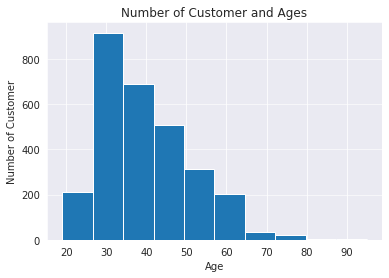

In [80]:
df['age'].plot.hist(grid=True, bins=10, rwidth=1)
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.grid(axis='y', alpha=0.75)

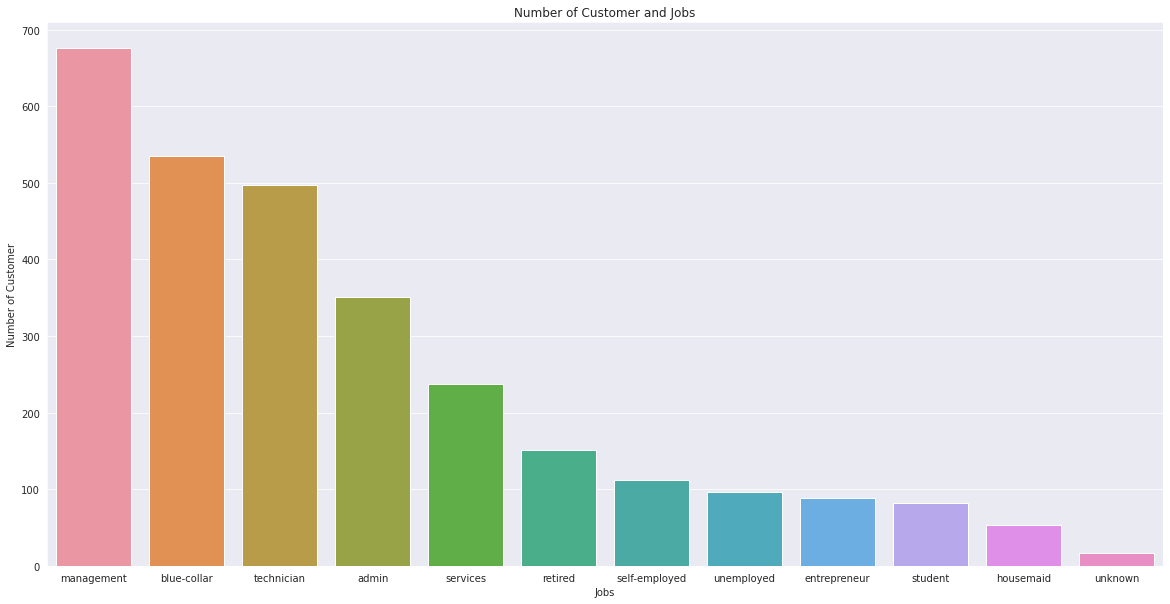

In [55]:
jobs = df.job.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
sns.barplot(x=jobs.index, y=jobs.values)
plt.title("Number of Customer and Jobs")
plt.xlabel("Jobs")
plt.ylabel("Number of Customer")
plt.show()

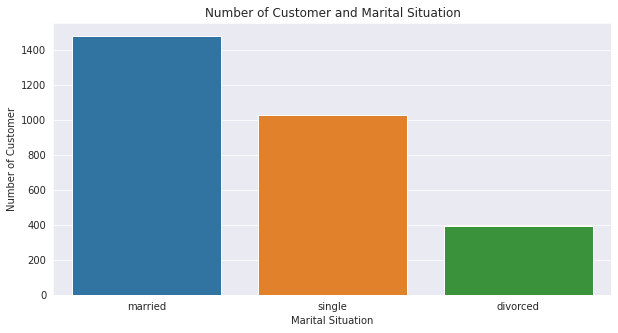

In [59]:
marital = df.marital.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=marital.index, y=marital.values)
plt.title("Number of Customer and Marital Situation")
plt.xlabel("Marital Situation")
plt.ylabel("Number of Customer")
plt.show()

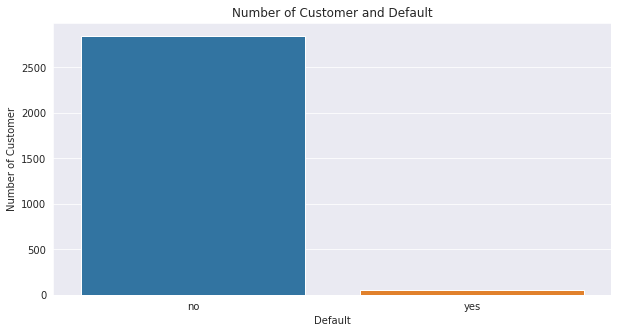

In [62]:
default = df.default.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=default.index, y=default.values)
plt.title("Number of Customer and Default")
plt.xlabel("Default")
plt.ylabel("Number of Customer")
plt.show()

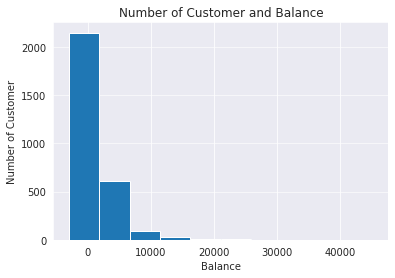

In [77]:
df['balance'].plot.hist(grid=True, bins=10, rwidth=1)
plt.title('Number of Customer and Balance')
plt.xlabel('Balance')
plt.ylabel('Number of Customer')
plt.grid(axis='y', alpha=0.75)

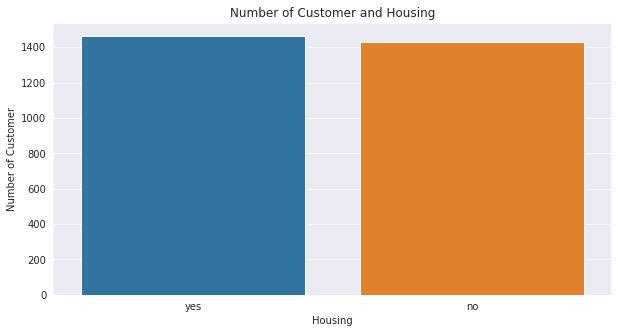

In [63]:
housing = df.housing.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=housing.index, y=housing.values)
plt.title("Number of Customer and Housing")
plt.xlabel("Housing")
plt.ylabel("Number of Customer")
plt.show()

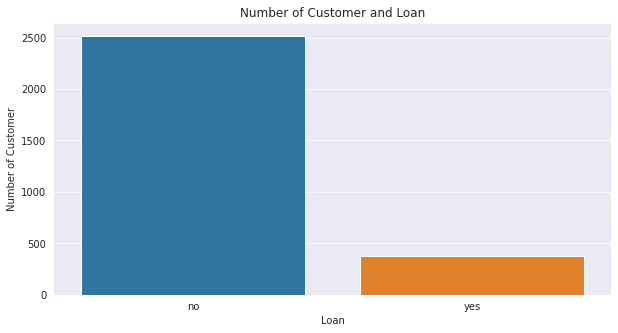

In [64]:
loan = df.loan.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=loan.index, y=loan.values)
plt.title("Number of Customer and Loan")
plt.xlabel("Loan")
plt.ylabel("Number of Customer")
plt.show()

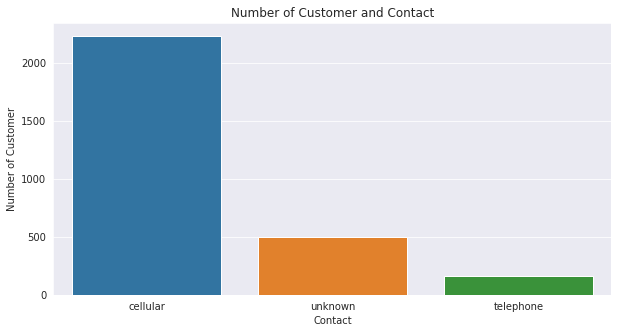

In [65]:
contact = df.contact.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=contact.index, y=contact.values)
plt.title("Number of Customer and Contact")
plt.xlabel("Contact")
plt.ylabel("Number of Customer")
plt.show()

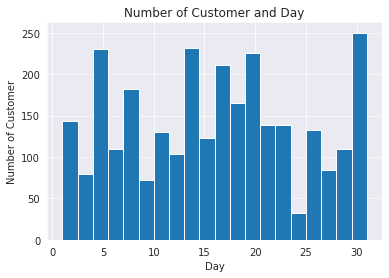

In [82]:
df['day'].plot.hist(grid=True, bins=20, rwidth=1)
plt.title('Number of Customer and Day')
plt.xlabel('Day')
plt.ylabel('Number of Customer')
plt.grid(axis='y', alpha=0.75)

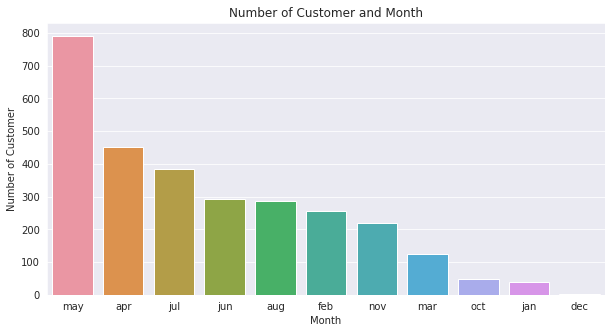

In [66]:
month = df.month.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=month.index, y=month.values)
plt.title("Number of Customer and Month")
plt.xlabel("Month")
plt.ylabel("Number of Customer")
plt.show()

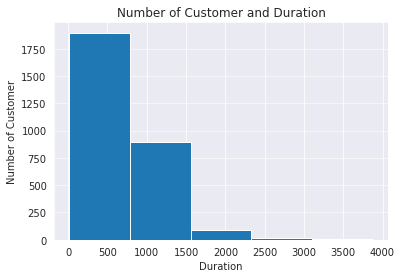

In [86]:
df['duration'].plot.hist(grid=True, bins=5, rwidth=1)
plt.title('Number of Customer and Duration')
plt.xlabel('Duration')
plt.ylabel('Number of Customer')
plt.grid(axis='y', alpha=0.75)

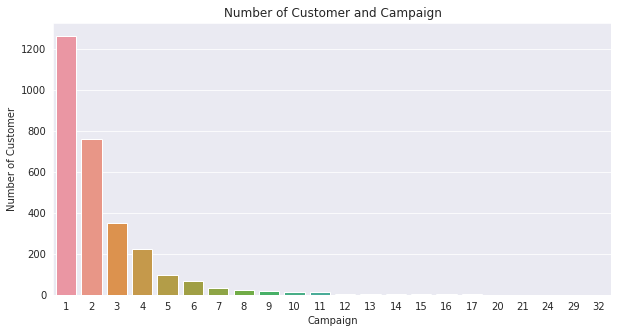

In [67]:
campaign = df.campaign.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=campaign.index, y=campaign.values)
plt.title("Number of Customer and Campaign")
plt.xlabel("Campaign")
plt.ylabel("Number of Customer")
plt.show()